In [90]:
from torchvision import models
import torch.nn as nn

In [101]:
def add_mixed_pooling_and_batch_norm(model, module):
  if isinstance(module, nn.Conv2d):
    conv_followed_by_bn = conv = False
    for next in model.modules():
      if conv and isinstance(next, nn.BatchNorm2d):
        conv_followed_by_bn = True
        break
      if isinstance(next, nn.Conv2d):
        conv = True
    if conv_followed_by_bn:
      return module
    else:
      return nn.Sequential(module, nn.BatchNorm2d(module.out_channels))
  elif isinstance(module, nn.MaxPool2d):
    # Replace MaxPool2d with MixedPooling
    return nn.Sequential(
      nn.MaxPool2d(kernel_size=module.kernel_size, stride=module.stride, padding=module.padding),
      nn.AvgPool2d(kernel_size=module.kernel_size, stride=module.stride, padding=module.padding)
    )
  elif isinstance(module, nn.Sequential):
    # Recursively go through Sequential modules
    return nn.Sequential(*(add_mixed_pooling_and_batch_norm(model, m) for m in module))
  else:
    return module
  

def optimize_model(model):
  # Apply changes recursively
  for name, module in model.named_children():
    setattr(model, name, add_mixed_pooling_and_batch_norm(model, module))
  return model


def get_pytorch_model(model_name : str, weights : str=None):
  if model_name == "resnet50": 
    return models.resnet50(weights=weights)
  elif model_name == "resnet101": 
    return models.resnet101(weights=weights)
  elif model_name == "resnet152": 
    return models.resnet152(weights=weights)
  elif model_name == "densenet121": 
    return models.densenet121(weights=weights)
  elif model_name == "densenet169": 
    return models.densenet169(weights=weights)
  elif model_name == "densenet201": 
    return models.densenet201(weights=weights)
  elif model_name == "alexnet":
    return models.alexnet(weights=weights)
  elif model_name == "vgg16": 
    return models.vgg16_bn(weights=weights)
  elif model_name == "vgg19": 
    return models.vgg19(weights=weights)
  elif model_name == "mobilenetv2":
    return models.mobilenet_v2(weights=weights)
  else: 
    raise ValueError(f"Invalid model_name {model_name}")


def modify_last_fcl(model, model_name):
  if model_name.startswith("densenet"):
    n_features = model.classifier.in_features
    model.classifier = nn.Linear(n_features, 2)
  elif model_name.startswith("vgg") or model_name.startswith("alexnet"):
    n_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(n_features, 2)])
    model.classifier = nn.Sequential(*features)
  elif model_name.startswith("mobilenet"):
    n_features = model.classifier[1].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(n_features, 2)])
    model.classifier = nn.Sequential(*features)
  else:
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, 2)

  return model


def init_model(
    model_name : str, 
    weights : str=None, 
    freeze_layers : bool=True,
    optimized : bool=False
): 
  model = get_pytorch_model(model_name, weights)
  
  if freeze_layers:
    for params in model.parameters(): 
      params.requires_grad = False

  # Parameters of newly constructed modules have requires_grad=True by default
  model = modify_last_fcl(model, model_name)

  return optimize_model(model) if optimized else model

In [92]:
weights = "IMAGENET1K_V1"
resnet50=models.resnet50(weights=weights),
resnet101=models.resnet101(weights=weights),
resnet152=models.resnet152(weights=weights),
densenet121=models.densenet121(weights=weights),
densenet169=models.densenet169(weights=weights),
densenet201=models.densenet201(weights=weights),
alexnet=models.alexnet(weights=weights),
vgg16=models.vgg16(weights=weights),
vgg19=models.vgg19(weights=weights),
mobilenetv2=models.mobilenet_v2(weights=weights)



In [104]:
print(init_model("resnet50",weights))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [105]:
print(init_model("resnet50",weights,True,True))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downs

In [13]:
metrics_800 = { 
    "train_loss": [0.008, 0.0123, 0.0198, 0.0208, 0.0206, 0.0206, 0.0206, 0.0530, 0.0028, 0.0028], 
    "train_acc": [0.9967, 0.9872, 0.9840, 0.9840, 0.9841, 0.9842, 0.9841, 0.9453, 0.9819, 0.9821], 
    "val_loss": [0.5777, 0.9914, 1.0401, 1.0615, 1.0293, 1.0433, 1.0414, 0.1244, 0.1236, 0.1216],
    "val_acc": [0.5227, 0.5227, 0.5227, 0.5227, 0.5227, 0.5227, 0.5227, 0.5227, 0.5227, 0.5227]
  }


metrics_2k = { 
    "train_loss": [0.0441,0.0431,0.0423,0.0419,0.0414,0.0410,0.0405,0.0205,0.0200,0.0199], 
    "train_acc": [0.5598,0.5745,0.5783,0.5810,0.5849,0.5873,0.5894,0.6563,0.6568,0.6568], 
    "val_loss": [0.0122,0.0110,0.0109,0.0108,0.0108,0.0106,0.0109,0.0098,0.0098,0.0099],
    "val_acc": [0.8038,0.8208,0.8100,0.8312,0.8204,0.8300,0.8223,0.8596,0.8600,0.8627]
  }

In [11]:
import matplotlib.pyplot as plt

def train_val_curves(values):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
    
    
    ax0.set_title("Loss")
    ax0.plot(values["train_loss"], label=f"Train")
    ax0.plot(values["val_loss"], label=f"Validation")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")

    ax1.set_title("Accuracy")
    ax1.plot(values["train_acc"], label=f"Train")
    ax1.plot(values["val_acc"], label=f"Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")

    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center")

    fig.show()

C:\Users\margarida\AppData\Local\Temp\ipykernel_15532\1029115663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


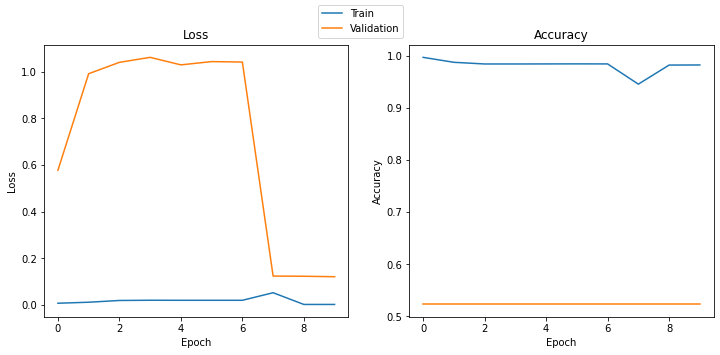

In [15]:
train_val_curves(metrics_800)

C:\Users\margarida\AppData\Local\Temp\ipykernel_15532\1029115663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


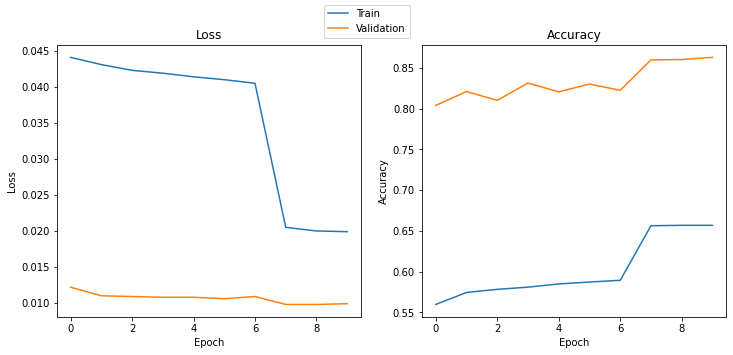

In [14]:
train_val_curves(metrics_2k)